In [5]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, SpatialDropout1D, LSTM, Dense, Bidirectional
from keras.models import load_model

from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt



In [6]:
# reads all .txt files in the path given and adds them to the list
def read_files(relative_path, ls):
    files = os.listdir(relative_path)
    files = list(filter(lambda x: x[-4:] == '.txt', files))

    for file in files:
        name = relative_path + "/" + file
        with open(name, 'r') as f:
            ls.append(f.read().replace('\n', ''))
            
        

In [7]:
#reading all data from different data sets
fake_data1 = pd.read_csv("../data/Fake and real news dataset/Fake.csv")
true_data1 = pd.read_csv("../data/Fake and real news dataset/True.csv")

#from another source - obtaining the contents of each .txt file as a string
fake_data2 = []
true_data2 = []

read_files("../data/fakeNewsDatasets/fakeNewsDataset/fake", fake_data2)     
read_files("../data/fakeNewsDatasets/celebrityDataset/fake", fake_data2)
read_files("../data/fakeNewsDatasets/fakeNewsDataset/legit", true_data2)
read_files("../data/fakeNewsDatasets/celebrityDataset/legit", true_data2)



In [8]:
#print("true_data1 dimensions:", true_data1.shape)
print("true_data1 (True.csv):")
print(true_data1.describe)
print("")
#print("fake_data1 dimensions:", fake_data1.shape)
print("fake_data1 (Fake.csv):")
print(fake_data1.describe)
#print(fake_data1.head())
#checking for invalid entries
print("true_data1 has null values:", true_data1.isnull().values.any())
print("fake_data1 has null values:", fake_data1.isnull().values.any())

true_data1 (True.csv):
<bound method NDFrame.describe of                                                    title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   


In [9]:
print("Number of observations in true_data2:", len(true_data2))
print("Number of observations in fake_data2:", len(fake_data2))

Number of observations in true_data2: 490
Number of observations in fake_data2: 490


In [10]:
# creates a bar plot of the counts of the most common words found in a dataset
def plot_top_counts(texts, top, plt_title):
    #list any irrelevant words that don't need to be considered
    unwanted = [ "to", "the", "for", "in", "of", "a", "and", "is", "says", "with", "as", "on", "at", "he", "his", "about", "their", "would", "which", "after"]
    #stores the counts of each work
    words = {}
    word = ""

    for text in texts:
        text = text.split(" ")

        for word in text:
            word = word.strip()
            word = word.strip(",")
            word = word.strip(".")
            word = word.strip("'")
            word = word.strip(":")

            if word.isalpha() and (word not in unwanted) and len(word) > 4:
                if word not in words:
                    words[word] = 1
                else:
                    words[word] += 1

    sorted_words = sorted(words.items(), key = lambda x: x[1], reverse = True)
    plotting_words = sorted_words[0:top]
    words_x = [tup[0] for tup in plotting_words]
    counts_y = [tup[1] for tup in plotting_words]

    
    
    plt.bar(range(len(plotting_words)), counts_y)
    plt.xticks(range(len(plotting_words)), words_x)
    plt.xlabel("Words")
    plt.ylabel("Counts")
    plt.title(plt_title)
    plt.show()




In [11]:
#creating 4 dataframes - true and false for each dataset
is_fake = [1 for x in range(len(fake_data1))]
fake_data1 = pd.DataFrame(list(fake_data1['text']), columns=['text'])
fake_data1['is_fake'] = is_fake
#print(fake_data1.head())

is_fake = [0 for x in range(len(true_data1))]
true_data1 = pd.DataFrame(list(true_data1['text']), columns=['text'])
true_data1['is_fake'] = is_fake
#print(true_data1.head())


is_fake = [1 for x in range(len(fake_data2))]
fake_data2 = pd.DataFrame(fake_data2, columns=['text'])
fake_data2['is_fake'] = is_fake

is_fake = [0 for x in range(len(true_data2))]
true_data2 = pd.DataFrame(true_data2, columns=['text'])
true_data2['is_fake'] = is_fake




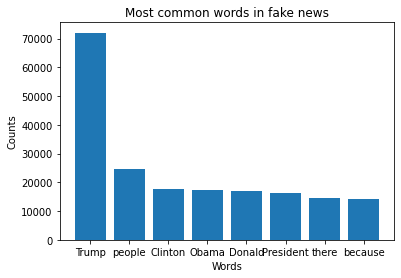

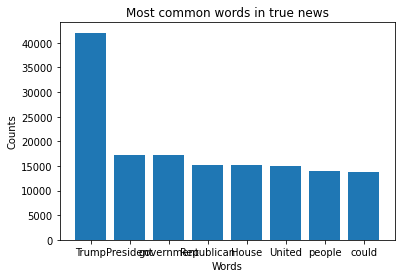

In [12]:
fake_words = list(fake_data1['text']) + list(fake_data2['text'])
true_words = list(true_data1['text']) + list(true_data2['text'])
plot_top_counts(fake_words, 8, "Most common words in fake news")
plot_top_counts(true_words, 8, "Most common words in true news")

In [13]:
#joining all data sets
frames = [true_data1, fake_data1, fake_data2, true_data2]
merged = pd.concat(frames)

merged.describe
merged = sk.utils.shuffle(merged)
print(merged.isnull().values.any())
#df.head()

False


In [14]:
#splitting data into training and tests sets
split = 0.2
train_txts, test_txts, train_res, test_res = train_test_split(merged['text'], merged['is_fake'], test_size=split, random_state=12)

In [15]:
#creating a word dictionaries where each word is assigned a unique number 
n_words = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer.fit_on_texts(train_txts)
train_seqs = tokenizer.texts_to_sequences(train_txts)
max_len = 1000

train_seqs = sequence.pad_sequences(train_seqs, maxlen=max_len)
test_seqs = tokenizer.texts_to_sequences(test_txts)
test_seqs = sequence.pad_sequences(test_seqs, maxlen=max_len)


In [16]:
#building model for analysing texts
#experiment with this 
inp_dim = max(tokenizer.word_index.values()) + 1
print(inp_dim)
#inp_dim = 5000
out_dim = 64

model = Sequential()
model.add(Embedding(inp_dim, out_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

128169
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          8202816   
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048032   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 10,251,393
Trainable params: 10,251,393
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
hist = model.fit(train_seqs, train_res, validation_data=(test_seqs, test_res), epochs=4, batch_size=4000)
#model.save("text_classifier.h5")

Epoch 1/4
10/10 [==============================] - 23s 2s/step - loss: 0.6900 - accuracy: 0.5379 - val_loss: 0.6686 - val_accuracy: 0.5862
Epoch 2/4
10/10 [==============================] - 22s 2s/step - loss: 0.6415 - accuracy: 0.6078 - val_loss: 0.5703 - val_accuracy: 0.6765
Epoch 3/4
10/10 [==============================] - 22s 2s/step - loss: 0.4510 - accuracy: 0.8383 - val_loss: 0.2779 - val_accuracy: 0.9199
Epoch 4/4
10/10 [==============================] - 21s 2s/step - loss: 0.1884 - accuracy: 0.9445 - val_loss: 0.1339 - val_accuracy: 0.9580


Accuracy: 95.80%


[]

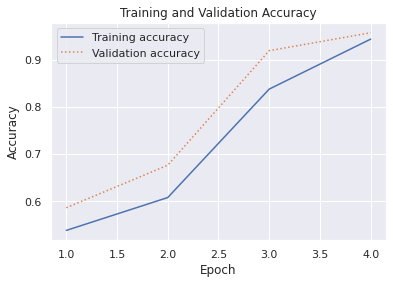

In [18]:
#plotting validation and training accuracy
scores = model.evaluate(test_seqs, test_res, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()



[]

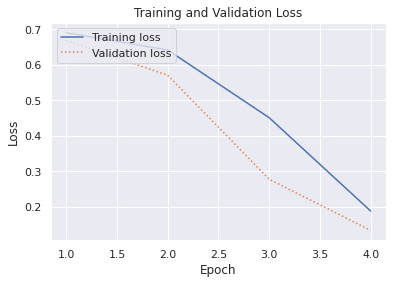

In [19]:
#plotting validation and training loss
acc = hist.history['loss']
val = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [20]:
#Returns a number between 0 and 1, determining how trustworthy the text is
#this function is similar to the first section of Microsoft's website:
#https://docs.microsoft.com/en-gb/learn/modules/analyze-review-sentiment-with-keras/3-use-neural-network-to-analyze-text-for-sentiment
# text can either by a string or a filepath to a .txt file
def predict_text(model, word_dict, max_seq_len, text):
    if (type(text) != str):
        return None
    
    #checking of a filepath is given
    if (text[-4:] == ".txt"):
        with open(text, "r") as file:
            text = file.read().replace('\n', '')
    # Transforming the text into an array of words which 
    # are all lower case, do not have have any punctuation marks    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.lower().split(' ')
    text = [word for word in text if word.isalpha()]
    
    #Creating a padded input tensor to feed into the model
    inp_dim = max(word_dict.values()) + 1
    input = [1]
    
    for word in text:
        if word in word_dict and word_dict[word] < inp_dim:
            input.append(word_dict[word])
        else:
            input.append(2)
            
    padded_input = sequence.pad_sequences([input], maxlen=max_seq_len)
    #print(len(padded_input[0]))
    #print(padded_input[0])

    result = model.predict(np.array([padded_input][0]))[0][0]

    return result
    
    

In [21]:
#loading saved model
#model = load_model("text_classifier.h5")

In [22]:
#example use of the predict_text function
text1 = "BrewDog threatened lawsuit against plan for bar with 'punk' in name BrewDog threatened legal action to prevent a bar from using the term punk in its name  it has emerged  a day after the brewer blamed trigger-happy lawyers for a similar dispute that sparked a social media backlash. The brewer  which has been a vocal critic of the behaviour of large corporations  raised an objection to plans by music promoter Tony Green to open a bar in Leeds called Draft Punk. Green  who says the name was a tongue-in-cheek reference to French dance music act Daft Punk  said the intimidating threat contravened the punk movement spirit that BrewDog claims to espouse."
text3 = "House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images."
text4 = "On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the following message in the event of an internal server error: https://t.co/zrWpyMXRcz pic.twitter.com/wiQSQNNzw0  Christopher Ingraham (@_cingraham) December 28, 2017That snippet of code appears to be on all https://t.co/dkhw0AlHB4 pages, which the footer says is paid for by the RNC? pic.twitter.com/oaZDT126B3  Christopher Ingraham (@_cingraham) December 28, 2017It s also all over https://t.co/ayBlGmk65Z. As others have noted in this thread, this is weird code and it s not clear it would ever actually display, but who knows.  Christopher Ingraham (@_cingraham) December 28, 2017After the coding was called out, the reference to Obama was deleted.UPDATE: The golf error message has been removed from the Trump and GOP websites. They also fixed the javascript  =  vs  ==  problem. Still not clear when these messages would actually display, since the actual 404 (and presumably 500) page displays a different message pic.twitter.com/Z7dmyQ5smy  Christopher Ingraham (@_cingraham) December 29, 2017That suggests someone at either RNC or the Trump admin is sensitive enough to Trump s golf problem to make this issue go away quickly once people noticed. You have no idea how much I d love to see the email exchange that led us here.  Christopher Ingraham (@_cingraham) December 29, 2017 The code was f-cked up.The best part about this is that they are using the  =  (assignment) operator which means that bit of code will never get run. If you look a few lines up  errorCode  will always be  404          (@tw1trsux) December 28, 2017trump s coders can t code. Nobody is surprised.  Tim Peterson (@timrpeterson) December 28, 2017Donald Trump is obsessed with Obama that his name was even in the coding of his website while he played golf again.Photo by Joe Raedle/Getty Images."
text5 = "The meme was an example of “copypasta,” defined by Dictionary.com as “a block of text which is repeatedly copied and pasted by individuals over various online forums and social media sites. The underlying assumptions the meme makes are problematic. For starters, the idea that there is a “nationwide conspiracy” to poison fast food orders would no doubt lead in the news, but as of this writing there were no news reports of any such widespread public health crisis. The claim in the meme is nothing more than a baseless rumor with no evidence offered. And Black Lives Matter is a national movement for social justice, not a membership-based organization, and activists who support it seek social equality and institutional reforms, not to cause physical harm to white people.his wasn’t the first time a false rumor about poisoned food circulated in the wake of Black Lives Matter demonstrations in 2020. A New York police union claimed that officers had been poisoned at a Shake Shack, but a police investigation found no criminal activity."
text6 = "According to a government factsheet, all airline crew are required to undertake quarantine upon arrival to Australia for 14 days, or until their next flight — whichever is shorter.However, airline workers flying between Australia and New Zealand are exempt from the quarantine period.'Exemptions for specific groups are granted because of the industry infection prevention requirements and training these groups have done' the factsheet reads. But aircrew are instructed to 'take care on layovers, use dedicated private transport [and] avoid crowded public spaces' as they monitor for coronavirus symptoms. Stay up"
text7 = "The Chinese are themselves planning to ban tik tok in India after seeing this video"
text8 = "A man has been shot dead and another wounded at a Black Lives Matter protest in the US state of Kentucky.The incident took place on Saturday evening (Kentucky time) at Jefferson Square Park in the centre of the city of Louisville where protesters had been have gathered for weeks over the killing of African-American woman Breonna Taylor.Ms Taylor, 26, was a medic who was shot dead in March by Louisville police officers when they raided her home looking for drugs, none of which were found.Her death helped fuel a campaign against racism and police brutality in the US that has since spread across the globe.Louisville Metro Police Department said officers were called to the park at around 9pm."
text9 = "sample_true1.txt"
print("expected true", predict_text(model, tokenizer.word_index, max_len, text1))
print("expected fake", predict_text(model, tokenizer.word_index, max_len, text3))
print("expected fake", predict_text(model, tokenizer.word_index, max_len, text4))
print("expected fake", predict_text(model, tokenizer.word_index, max_len, text5))
print("expected true", predict_text(model, tokenizer.word_index, max_len, text6))
print("expected fake", predict_text(model, tokenizer.word_index, max_len, text7))
print("expected true", predict_text(model, tokenizer.word_index, max_len, text8))
print("expected true", predict_text(model, tokenizer.word_index, max_len, text9))


expected true 0.1347107
expected fake 0.94625765
expected fake 0.9992323
expected fake 0.81966794
expected true 0.24719442
expected fake 0.91456324
expected true 0.298884
expected true 0.22587779
